In [1]:
import gym
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch

In [3]:
gym.__version__

'0.21.0'

In [4]:
env_name = 'CartPole-v1'#'RocketLander-v0'#

# Test code

In [3]:
env = gym.make(env_name)
init_state = env.reset()

while True:
    env.render()
    action = env.action_space.sample()
    observation, reward, done, info =env.step(action)

    if done:
        print("Simulation done.")
        break
env.close()

Simulation done.


# Introducing parametrised policy

In [5]:
obs_len = init_state.size

In [6]:
model = torch.nn.Sequential(
    torch.nn.Linear(obs_len, 128), 
    torch.nn.ReLU(),
    
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    
    torch.nn.Linear(64, 2)   
)

In [79]:
logits = model(torch.tensor(init_state, dtype=torch.float32))
probs = torch.nn.functional.softmax(logits, dim=0)

dist = torch.distributions.categorical.Categorical(probs=probs)
int(dist.sample())

1

In [80]:
def play_game(env, model, render=False):
    observation = env.reset()

    observations, rewards = [], []
    while True:
        if render:
            env.render()
        logits = model(torch.tensor(observation, dtype=torch.float32))
        probs = torch.nn.functional.softmax(logits, dim=0)
        dist = torch.distributions.categorical.Categorical(probs=probs)
        
        
        action = int(dist.sample()) #env.action_space.sample()
        observation, reward, done, info = env.step(action)
        
        observations.append(list(observation))
        rewards.append(reward)
        
        if done:
            break
    env.close()
    
    return observations, rewards

In [93]:
env = gym.make(env_name)
observations, rewards = play_game(env, model, render=True)

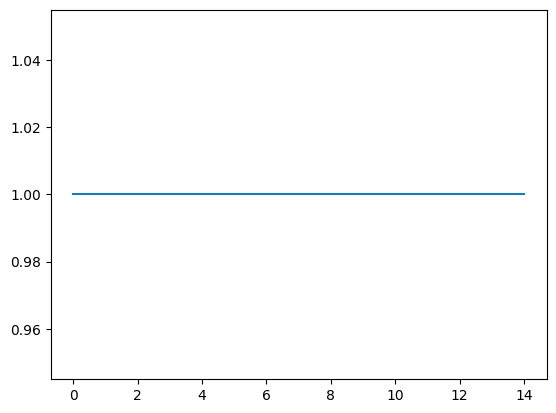

In [78]:
plt.plot(rewards)

# Adding loss function

Loss is just mean reward per trajectory. So we will try to play 100 games and each time save the sum of rewards weighted by the logit given to it by the model. At the end we will obtain the tensor if length 100 on which we will be able to make backpropogation.

In [95]:
# We are chaning the play_game function to also output logits

def play_game(env, model, render=False):
    observation = env.reset()

    observations, rewards, actions, logits = [], [], [], []
    while True:
        if render:
            env.render()
        logit = model(torch.tensor(observation, dtype=torch.float32))
        probs = torch.nn.functional.softmax(logit, dim=0)
        dist = torch.distributions.categorical.Categorical(probs=probs)
        
        
        action = int(dist.sample()) #env.action_space.sample()
        observation, reward, done, info = env.step(action)
        
        observations.append(list(observation))
        rewards.append(reward)
        actions.append(action)
        logits.append(logit)
        
        if done:
            break
    env.close()
    
    return observations, rewards, actions, logits

In [97]:
env = gym.make(env_name)
observations, rewards, actions, logits = play_game(env, model, render=False)

In [101]:
actions

[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]

In [103]:
torch.stack(logits)

tensor([[-0.0311, -0.0903],
        [-0.0360, -0.0791],
        [-0.0491, -0.0710],
        [-0.0597, -0.0626],
        [-0.0482, -0.0706],
        [-0.0347, -0.0777],
        [-0.0476, -0.0707],
        [-0.0596, -0.0616],
        [-0.0689, -0.0514],
        [-0.0590, -0.0610],
        [-0.0466, -0.0701],
        [-0.0583, -0.0601],
        [-0.0464, -0.0697],
        [-0.0320, -0.0810],
        [-0.0454, -0.0705],
        [-0.0576, -0.0599],
        [-0.0673, -0.0518]], grad_fn=<StackBackward0>)

In [107]:
acts_one_hot = torch.nn.functional.one_hot(torch.tensor(actions), 2)
acts_one_hot

tensor([[1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]])

In [110]:
len(acts_one_hot)

17

In [113]:
selected_logits = torch.sum(torch.stack(logits) * acts_one_hot, dim=-1)

In [114]:
selected_logits

tensor([-0.0311, -0.0360, -0.0491, -0.0626, -0.0706, -0.0347, -0.0476, -0.0596,
        -0.0514, -0.0610, -0.0466, -0.0601, -0.0697, -0.0320, -0.0454, -0.0576,
        -0.0673], grad_fn=<SumBackward1>)

In [117]:
sum_weighted_rewards = selected_logits.sum()

In [118]:
sum_weighted_rewards

tensor(-0.8825, grad_fn=<SumBackward0>)

Now we can backprop

In [122]:
opt = torch.optim.Adam(model.parameters())
opt.zero_grad()

In [123]:
sum_weighted_rewards.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [128]:
opt.step()

In [136]:
list(model.parameters())[-2][0]

tensor([-0.0334, -0.0588,  0.0884, -0.0899,  0.0673,  0.1080, -0.0281,  0.0090,
         0.0822, -0.0831, -0.0069, -0.0786, -0.0998, -0.0987,  0.0796, -0.0967,
         0.0642, -0.1132,  0.0367, -0.0777, -0.1235, -0.0483, -0.0209, -0.0415,
         0.0673, -0.0956,  0.0274,  0.0785,  0.0760,  0.0313, -0.0254,  0.0018,
        -0.0227,  0.0651, -0.0850,  0.0830, -0.0503,  0.0927, -0.0382, -0.1111,
         0.0053, -0.0882, -0.1105,  0.0452,  0.1110, -0.0519, -0.0487,  0.0451,
        -0.0230, -0.0724,  0.1114,  0.0140,  0.0575,  0.0017, -0.0245,  0.0368,
        -0.0416, -0.0755,  0.1249, -0.0188,  0.1008,  0.0707, -0.0870, -0.0033],
       grad_fn=<SelectBackward0>)

Looping the weights update

In [284]:
model = torch.nn.Sequential(
    torch.nn.Linear(obs_len, 128), 
    torch.nn.ReLU(),
    
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    
    torch.nn.Linear(64, 2),
    torch.nn.LogSoftmax()
)

In [285]:
env = gym.make(env_name)
opt = torch.optim.Adam(model.parameters())

In [207]:
for _ in range(100):
    observations, rewards, actions, logits = play_game(env, model, render=False)

    acts_one_hot = torch.nn.functional.one_hot(torch.tensor(actions), 2)
    selected_logits = torch.sum(torch.stack(logits) * acts_one_hot, dim=-1)
    sum_weighted_rewards = selected_logits.sum()
#     print(sum_weighted_rewards)
    opt.zero_grad()
    sum_weighted_rewards.backward()
    opt.step()

In [212]:
observations, rewards, actions, logits  = play_game(env, model, render=True)

In [203]:
logits

[tensor([-1.0798, -0.4150], grad_fn=<LogSoftmaxBackward0>),
 tensor([-1.0680, -0.4211], grad_fn=<LogSoftmaxBackward0>),
 tensor([-1.1036, -0.4030], grad_fn=<LogSoftmaxBackward0>),
 tensor([-1.0665, -0.4219], grad_fn=<LogSoftmaxBackward0>),
 tensor([-1.0819, -0.4139], grad_fn=<LogSoftmaxBackward0>),
 tensor([-1.0660, -0.4222], grad_fn=<LogSoftmaxBackward0>),
 tensor([-1.0951, -0.4072], grad_fn=<LogSoftmaxBackward0>),
 tensor([-1.1642, -0.3742], grad_fn=<LogSoftmaxBackward0>),
 tensor([-1.2482, -0.3383], grad_fn=<LogSoftmaxBackward0>),
 tensor([-1.3370, -0.3047], grad_fn=<LogSoftmaxBackward0>),
 tensor([-1.4304, -0.2734], grad_fn=<LogSoftmaxBackward0>),
 tensor([-1.5256, -0.2452], grad_fn=<LogSoftmaxBackward0>),
 tensor([-1.6124, -0.2224], grad_fn=<LogSoftmaxBackward0>),
 tensor([-1.7044, -0.2007], grad_fn=<LogSoftmaxBackward0>)]

In [204]:
actions

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# Extending rewards to the future

The sum weighted reward as out loss function does not grow. Let's change it by changing the immidiate reward to sum of rewards from that time step to the end of the trajectory.

In [214]:
rewards[::-1]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [220]:
np.cumsum(rewards[::-1])[::-1]

array([12., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.])

In [219]:
np.cumsum([1,2,3][::-1])[::-1]

array([6, 5, 3])

In [395]:
model = torch.nn.Sequential(
    torch.nn.Linear(obs_len, 128), 
    torch.nn.ReLU(),
    
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    
    torch.nn.Linear(64, 2),
    torch.nn.LogSoftmax()
)

env = gym.make(env_name)
opt = torch.optim.Adam(model.parameters())

In [324]:
losses = []
for _ in range(600):
    observations, rewards, actions, logits = play_game(env, model, render=False)
    
    cum_rewards = np.cumsum(rewards[::-1])[::-1]
    cum_rewards = torch.tensor(list(cum_rewards), dtype=torch.float32)
    
    acts_one_hot = torch.nn.functional.one_hot(torch.tensor(actions), 2)
    selected_logits = torch.sum(torch.stack(logits) * acts_one_hot, dim=-1)
    sum_weighted_rewards = -(selected_logits * cum_rewards).sum()
    losses.append(sum(rewards))
#     print(sum_weighted_rewards)

    opt.zero_grad()
    sum_weighted_rewards.backward()
    opt.step()

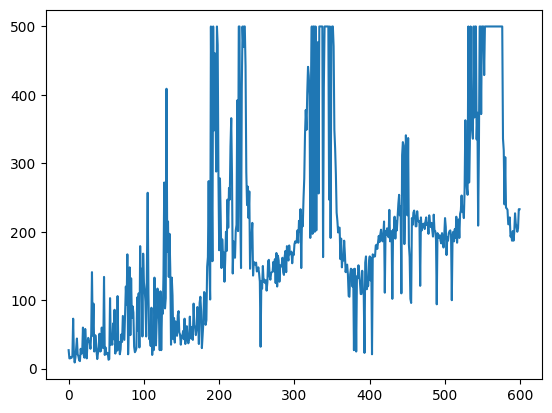

In [325]:
plt.plot(losses)

In [366]:
observations, rewards, actions, logits = play_game(env, model, render=True)

/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [367]:
sum(rewards)

231.0

We will now attempt to reduce noise in policy (model weights) updates. It should reduce the chance that policy is updated negatively and gets stuck.

# Adding discount to sum of rewards

In [102]:
DISCOUNT = 0.99

In [380]:
tmp_rewards = torch.tensor(rewards[:10], dtype=torch.float32)

In [381]:
tmp_rewards

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [382]:
discounts = torch.tensor([DISCOUNT**power for power in range(len(tmp_rewards))], dtype=torch.float32)
discounts

tensor([1.0000, 0.9000, 0.8100, 0.7290, 0.6561, 0.5905, 0.5314, 0.4783, 0.4305,
        0.3874])

In [383]:
disc_tmp_rews = tmp_rewards * discounts

In [385]:
disc_tmp_rews.flip(dims=(0,)).cumsum(0).flip(dims=(0,))

tensor([6.5132, 5.5132, 4.6132, 3.8032, 3.0742, 2.4181, 1.8276, 1.2962, 0.8179,
        0.3874])

In [394]:
def create_cum_rewards(rewards, discount=DISCOUNT):
    loc_rewards = torch.tensor(rewards, dtype=torch.float32)
    discounts = torch.tensor([discount**power for power in range(len(loc_rewards))], dtype=torch.float32)
    disc_rewards = loc_rewards * discounts

    return disc_rewards.flip(dims=(0,)).cumsum(0).flip(dims=(0,))
    

In [378]:
create_cum_rewards(rewards)

tensor([1.0000e+01, 9.0000e+00, 8.1000e+00, 7.2900e+00, 6.5610e+00, 5.9049e+00,
        5.3144e+00, 4.7830e+00, 4.3047e+00, 3.8742e+00, 3.4868e+00, 3.1381e+00,
        2.8243e+00, 2.5419e+00, 2.2877e+00, 2.0589e+00, 1.8530e+00, 1.6677e+00,
        1.5009e+00, 1.3509e+00, 1.2158e+00, 1.0942e+00, 9.8477e-01, 8.8629e-01,
        7.9766e-01, 7.1790e-01, 6.4611e-01, 5.8150e-01, 5.2335e-01, 4.7101e-01,
        4.2391e-01, 3.8152e-01, 3.4337e-01, 3.0903e-01, 2.7813e-01, 2.5032e-01,
        2.2528e-01, 2.0276e-01, 1.8248e-01, 1.6423e-01, 1.4781e-01, 1.3303e-01,
        1.1973e-01, 1.0775e-01, 9.6977e-02, 8.7280e-02, 7.8552e-02, 7.0697e-02,
        6.3627e-02, 5.7264e-02, 5.1538e-02, 4.6384e-02, 4.1746e-02, 3.7571e-02,
        3.3814e-02, 3.0433e-02, 2.7389e-02, 2.4650e-02, 2.2185e-02, 1.9967e-02,
        1.7970e-02, 1.6173e-02, 1.4556e-02, 1.3100e-02, 1.1790e-02, 1.0611e-02,
        9.5500e-03, 8.5950e-03, 7.7355e-03, 6.9620e-03, 6.2658e-03, 5.6392e-03,
        5.0753e-03, 4.5678e-03, 4.1110e-

In [417]:
model = torch.nn.Sequential(
    torch.nn.Linear(obs_len, 128), 
    torch.nn.ReLU(),
    
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    
    torch.nn.Linear(64, 2),
    torch.nn.LogSoftmax()
)

env = gym.make(env_name)
opt = torch.optim.Adam(model.parameters())

In [418]:
losses = []
for _ in range(1500):
    observations, rewards, actions, logits = play_game(env, model, render=False)

    cum_rewards = create_cum_rewards(rewards)
    
    acts_one_hot = torch.nn.functional.one_hot(torch.tensor(actions), 2)
    selected_logits = torch.sum(torch.stack(logits) * acts_one_hot, dim=-1)
    sum_weighted_rewards = -(selected_logits * cum_rewards).sum()
    losses.append(sum(rewards))
#     print(sum_weighted_rewards)

    opt.zero_grad()
    sum_weighted_rewards.backward()
    opt.step()

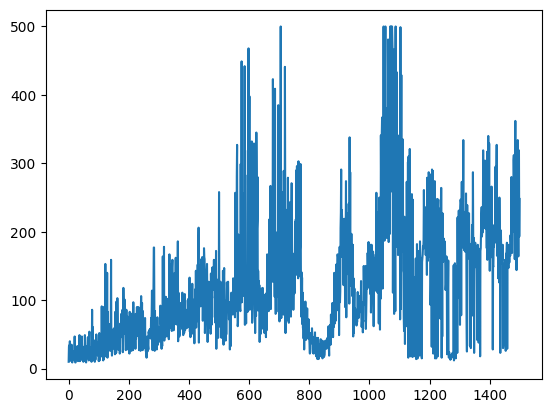

In [419]:
plt.plot(losses)

In [420]:
sum(rewards)

248.0

In [415]:
observations, rewards, actions, logits  = play_game(env, model, render=True)

# Adding batches

In [478]:
BATCH_SIZE = 100

In [479]:
def generate_batch_loss(env, model, discount=DISCOUNT, batch_size=BATCH_SIZE):
    all_losses = torch.zeros(batch_size)
    all_rewards = []
    for cnt in range(batch_size):
        observations, rewards, actions, logits = play_game(env=env, model=model, render=False)

        cum_rewards = create_cum_rewards(rewards, discount=discount)

        acts_one_hot = torch.nn.functional.one_hot(torch.tensor(actions), 2)
        selected_logits = torch.sum(torch.stack(logits) * acts_one_hot, dim=-1)
        sum_weighted_rewards = -(selected_logits * cum_rewards).sum()
        
        all_losses[cnt] = sum_weighted_rewards
        all_rewards.append(np.sum(rewards))
        
    return np.mean(all_rewards), all_losses.mean()

In [486]:
model = torch.nn.Sequential(
    torch.nn.Linear(obs_len, 128), 
    torch.nn.ReLU(),
    
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    
    torch.nn.Linear(64, 2),
    torch.nn.LogSoftmax()
)

env = gym.make(env_name)
opt = torch.optim.Adam(model.parameters())

In [487]:
rews = []
for _ in range(300):
    mean_batch_reward, mean_batch_loss = generate_batch_loss(env, model, discount=DISCOUNT, batch_size=BATCH_SIZE)
    rews.append(mean_batch_reward)
#     print(sum_weighted_rewards)

    opt.zero_grad()
    mean_batch_loss.backward()
    opt.step()
    
    if _%10 == 0:
        print(_, ' : ', mean_batch_reward)

0  :  23.61
10  :  30.86
20  :  48.73
30  :  62.26
40  :  129.14
50  :  250.02
60  :  304.09
70  :  352.75
80  :  408.96
90  :  324.22
100  :  386.14
110  :  308.26
120  :  433.3
130  :  410.6
140  :  470.85
150  :  451.94
160  :  498.6
170  :  383.33
180  :  460.44
190  :  331.2
200  :  441.05
210  :  485.92
220  :  498.45
230  :  489.93
240  :  500.0
250  :  498.69
260  :  455.75
270  :  486.02
280  :  470.46
290  :  483.78


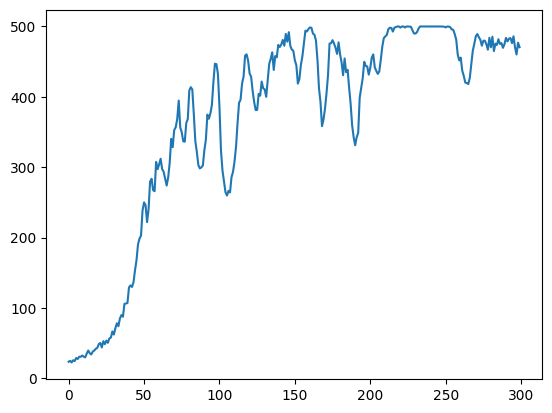

In [488]:
plt.plot(rews)

In [511]:
observations, rewards, actions, logits  = play_game(env, model, render=True)

In [512]:
sum(rewards)

500.0

Implemented algo is batch monte carlo policy gradient, or batch REINFORCE.
There's much less variance in the sum of rewards between games, therefore, updates to policy is less noisy. Performance that previousy took over 600 updates is now reached within around 250 steps. There are more games played, but less gradient descent steps, i.e. policy updates. We will now attempt to use same approach on an environment with continuous action space.

# Using batch REINFORCE on the Pendulum-v1 env

Almost everything could be reused except for 2 things:
* action sampling: <br>
    Action space is continuous in this env, so distribution needs to be changed from categorical to normal
* MLP architecture: <br>
    Previously the NN output logprobabilities of 2 actions, now it should output means and std of 3 distributions, one per each action

In [16]:
from IPython.display import clear_output

In [17]:
env_name = 'Pendulum-v1' #'MountainCarContinuous-v0'

DISCOUNT = .9

env = gym.make(env_name)
init_state = env.reset()
obs_len = len(init_state)

In [18]:
class ParameterisedPolicy(torch.nn.Module):
    
    def __init__(self, obs_len=obs_len):
        super().__init__()
        self.obs_len = obs_len
        self.lin_1 = torch.nn.Linear(self.obs_len, 256)
        self.rel_1 = torch.nn.ReLU()
            
        self.lin_2 = torch.nn.Linear(256, 1)
        
        self.lin_3 = torch.nn.Linear(256, 1)
        self.elu = torch.nn.ELU()
        
        
    def forward(self, x):
        x = self.lin_1(x)
        x = self.rel_1(x)
        
        mu = self.lin_2(x)
        
        x = self.lin_3(x)
        sigma = self.elu(x) + 1.000001
        
        return mu, sigma
    
    
model = ParameterisedPolicy()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [344]:
observation = env.reset()

In [345]:
params = model(torch.tensor(observation, dtype=torch.float32))

In [346]:
params

(tensor([0.1549], grad_fn=<AddBackward0>),
 tensor([0.7530], grad_fn=<AddBackward0>))

In [295]:
all_params = []
for _ in range(50000):
    observation = env.reset()
    
    model = ParameterisedPolicy(obs_len=obs_len)
    opt = torch.optim.Adam(model.parameters(), lr=0.0005)

    params = model(torch.tensor(observation, dtype=torch.float32))
    all_params.append(params)    

Text(0.5, 0, 'sigma')

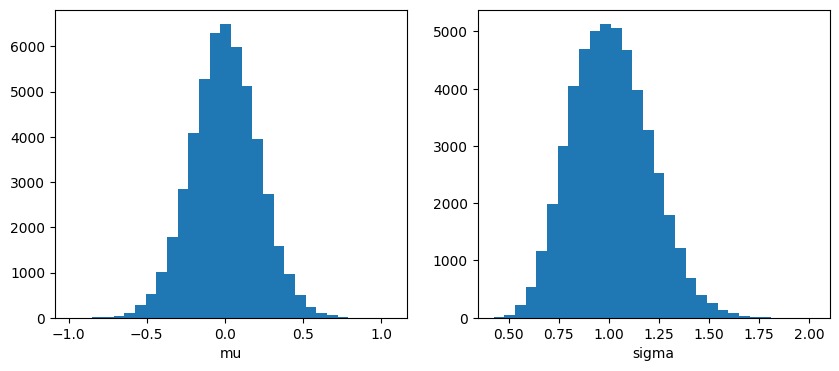

In [209]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))
ax1.hist(torch.tensor(all_params)[:, 0], bins=30); ax1.set_xlabel('mu')
ax2.hist(torch.tensor(all_params)[:, 1], bins=30); ax2.set_xlabel('sigma')

We can see that the ouput layers allow to set both positive and negative means of action distribution, while sigmas are only positive, as required.

In [19]:
def create_cum_rewards(rewards, discount=DISCOUNT):
    new_rews = [0]
    for el in rewards[::-1]:
        val = el + discount * new_rews[-1]
        new_rews.append(val)
    return torch.tensor(new_rews[1:][::-1], dtype=torch.float32)


def play_game(env, model, n_steps=300, render=False):
    observation = env.reset()

    rewards, logits = [], []
    for _ in range(n_steps):
        if render:
            env.render()
            
        (mu, sigma) = model(torch.tensor(observation, dtype=torch.float32))
        m = torch.distributions.normal.Normal(mu, sigma)
        action = m.sample()
        observation, reward, done, info = env.step([action.detach().numpy()[0]])
        logit = m.log_prob(action)   

        rewards.append(reward)
        logits.append(logit)
        
        if done:
            break
    env.close()
    
    return rewards, logits

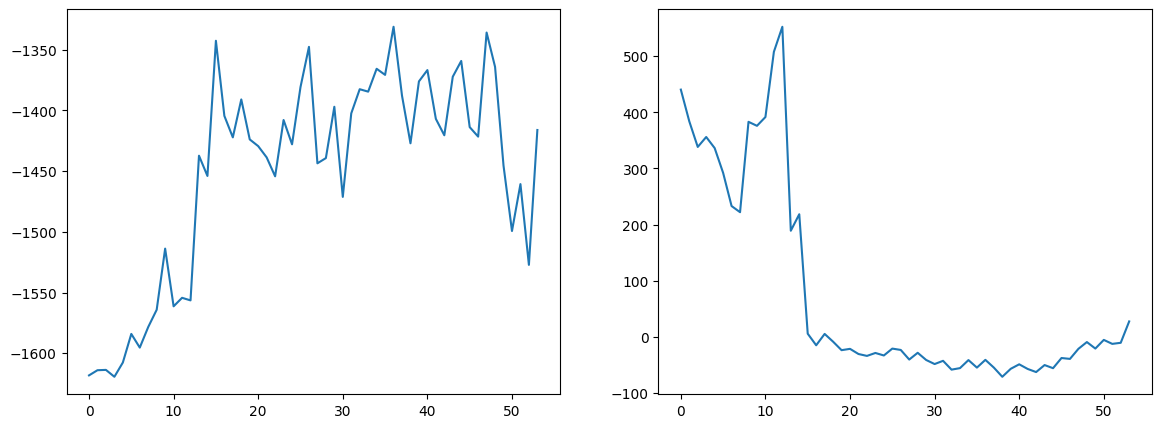

KeyboardInterrupt: 

In [27]:
rews, losses = [], []
for _ in range(int(2e4)):
    rewards, logits = play_game(env, model, render=False)
    
    cum_rewards = create_cum_rewards(rewards, discount=DISCOUNT)
    stacked_logits = torch.stack(logits).flatten()#torch.stack(logits)
    loss = -(stacked_logits * cum_rewards).mean()

    rews.append(np.sum(rewards))
    losses.append(loss)
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if _%50 == 0:
        clear_output()
        if _ > 1:
            
            stacked_losses = torch.stack(losses)
            fig, ax = plt.subplots(1,2, figsize=(14,5))
            ax[0].plot(np.array(rews[:-1]).reshape(-1, 50).mean(axis=-1))
            ax[1].plot(np.array(stacked_losses[:-1].detach().numpy()).reshape(-1, 50).mean(axis=-1))
            
        
        
        plt.show()

Model does not learn. Because the arch is simple, there might be problems with gradients. Let's check if they explode.

In [28]:
stacked_logits

tensor([-1.2866, -0.9842, -1.6090, -1.7499, -1.5680, -1.9472, -1.3639, -1.3522,
        -2.5183, -1.4071, -1.5280, -4.1449, -1.4476, -1.3504, -1.7614, -0.4939,
        -0.4429,  0.5886,  0.5497,  1.2052,  1.3798,  1.6398,  3.1280,  1.7160,
         3.1960,  2.6962,  3.3600,  3.4873,  1.8947,  2.2508,  2.0755, -1.0701,
        -0.6735, -3.8318, -0.4385, -2.5254, -1.2271, -2.3450, -1.7439, -1.8265,
        -2.0688, -1.8173, -3.2508, -3.5432, -1.7822, -2.5372, -1.2580, -1.3205,
        -0.9457, -0.8787, -1.0598,  0.5400,  1.0556,  0.6255,  1.0344,  2.4623,
         2.4561,  3.1842,  3.2786,  3.4297,  3.4388,  3.0290,  2.5044,  2.2764,
         1.9107,  1.2958,  0.4805, -0.3222, -1.3614, -1.0374, -1.6385, -2.1624,
        -1.8716, -2.5352, -2.1439, -2.6422, -2.0291, -2.0103, -2.1153, -1.9125,
        -2.6791, -2.9680, -1.5761, -3.6641, -0.1063,  0.5388,  1.7231,  2.6085,
         3.7359,  4.9137,  5.8340,  6.7646,  7.3043,  7.6003,  7.6331,  7.0777,
         6.4455,  4.4973,  4.9437,  3.73

In [204]:
def draw_gradients_rewards(model, rewards, ave_over_steps):
    
    fig, axs = plt.subplot_mosaic([['1', '1', '1'], ['2', '3', '4']],
                                  constrained_layout=False, figsize=(20,10))

    axs['1'].plot(np.array(rewards[:ave_over_steps*(len(rewards)//ave_over_steps)])\
                    .reshape(-1, ave_over_steps).mean(axis=-1))

    axs['2'].hist(model.lin_1.weight.grad.flatten().detach().numpy(), bins=50); 
    axs['2'].set_xlabel('Grads in dense layer 1')

    axs['3'].hist(model.lin_2.weight.grad.flatten().detach().numpy(), bins=50); 
    axs['3'].set_xlabel('Grads in dense layer 2')

    axs['4'].hist(model.lin_3.weight.grad.flatten().detach().numpy(), bins=50); 
    axs['4'].set_xlabel('Grads in dense layer 3')

def check_for_bad_gradients(model, threshold=1e6):
    flag = False
    all_grads = list(model.lin_1.weight.grad.flatten().detach().numpy()) + \
                list(model.lin_2.weight.grad.flatten().detach().numpy()) + \
                list(model.lin_3.weight.grad.flatten().detach().numpy())
    
    if any(abs(np.array(all_grads)) >= threshold):
        flag = True
    return flag

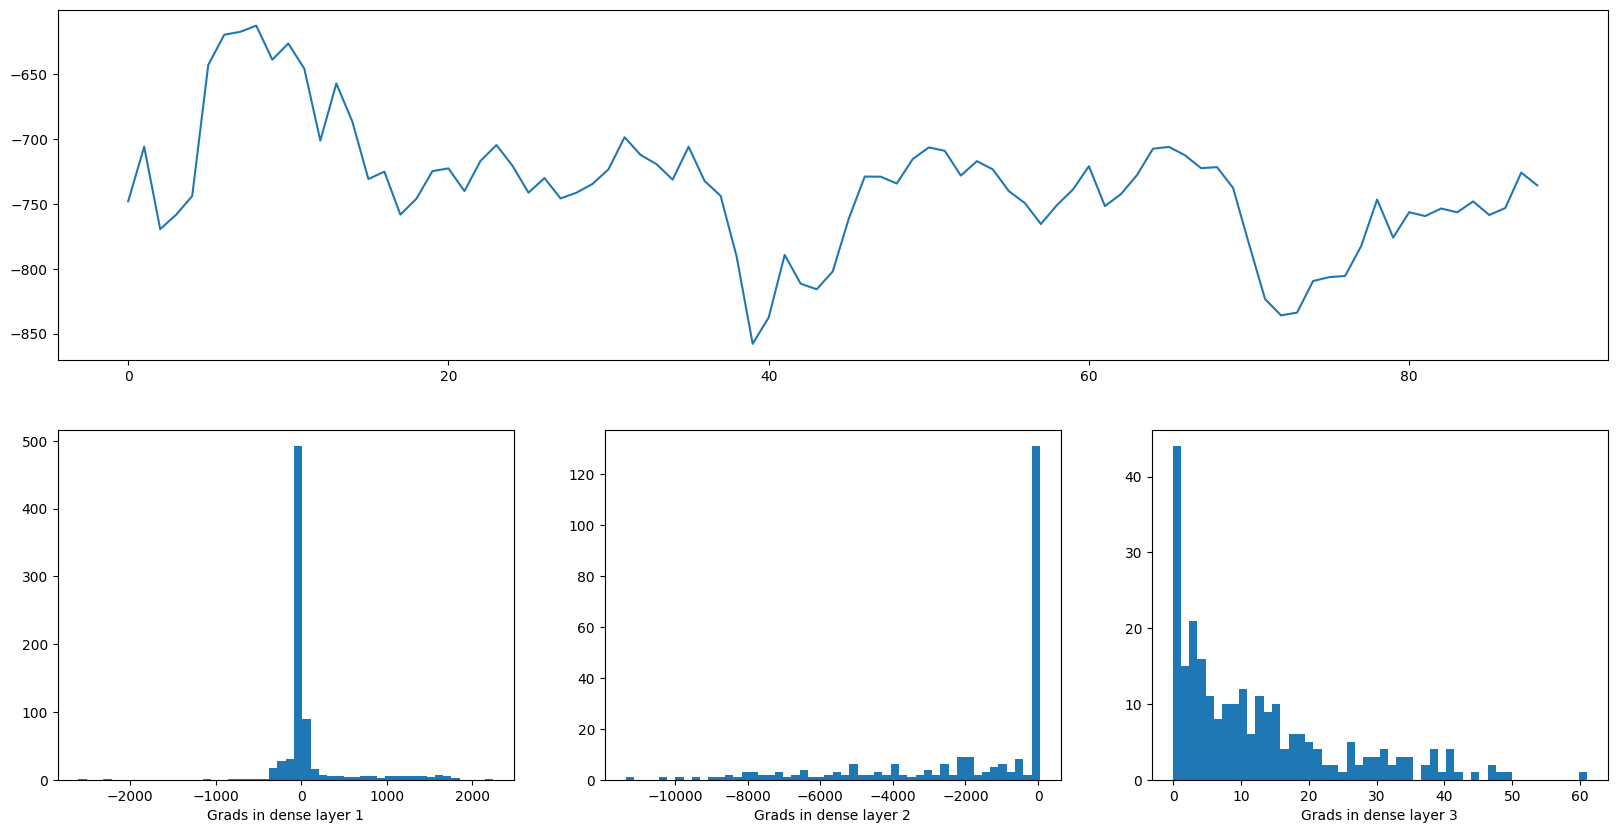

Step 4469
KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!KABOOOOOOOOM!!!


In [37]:
model = ParameterisedPolicy()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

rews = []
for _ in range(int(5e4)):
    rewards, logits = play_game(env, model, n_steps=100, render=False)
    
    cum_rewards = create_cum_rewards(rewards, discount=DISCOUNT)
    stacked_logits = torch.stack(logits).flatten()
    loss = -(stacked_logits * cum_rewards).mean()

    rews.append(np.sum(rewards))

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if _%100 == 0:
        if _ > 1:
            clear_output()
            draw_gradients_rewards(model, rewards=rews)
            plt.show()
            
    if check_for_bad_gradients(model):
        clear_output()
        draw_gradients_rewards(model, rewards=rews)
        plt.show()
        print('Step', _)
        print('KABOOOOOOOOM!!!'*30)
        break
        
    

To deal with exploding gradients we introduce gradients clipping. Interestingly, in the sense of the RL problem posed this measure is a proxy for limiting the policy change in one step. We effectively limit by how much we change the policy parameters, hence we limit the update of policy. Although we do not measure the policy change explicitly so can not be sure how limitation on parameters limits that policy change. 

Let's check linear layers grad means to see how much we want to cut off.

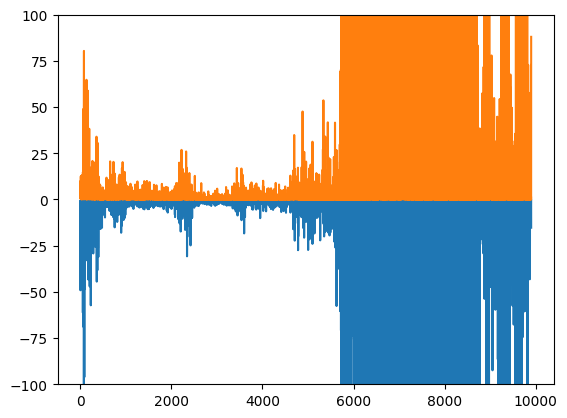

In [92]:
model = ParameterisedPolicy()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

grads_perc_10, grads_perc_90 = [], []
for _ in range(int(1e4)):
    rewards, logits = play_game(env, model, n_steps=20, render=False)
    
    cum_rewards = create_cum_rewards(rewards, discount=DISCOUNT)
    stacked_logits = torch.stack(logits).flatten()
    loss = -(stacked_logits * cum_rewards).mean()

    rews.append(np.sum(rewards))

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    all_grads = list(model.lin_1.weight.grad.flatten().detach().numpy()) + \
                list(model.lin_2.weight.grad.flatten().detach().numpy()) + \
                list(model.lin_3.weight.grad.flatten().detach().numpy())
    grads_perc_10.append(np.percentile(all_grads, 10))
    grads_perc_90.append(np.percentile(all_grads, 90))
    
    if _%100==0:
        clear_output()
        plt.plot(grads_perc_10)
        plt.plot(grads_perc_90)
        plt.ylim(-100, 100)
        plt.show()

Explosion is well visible on the graph above. We are not trying to find the absolute best solution for the environment so a rough estimation for the cut off value should suffice. It should be somewhere between 10 and a 100. To further reduce the probability of updates too great, we will decay the learning rate.

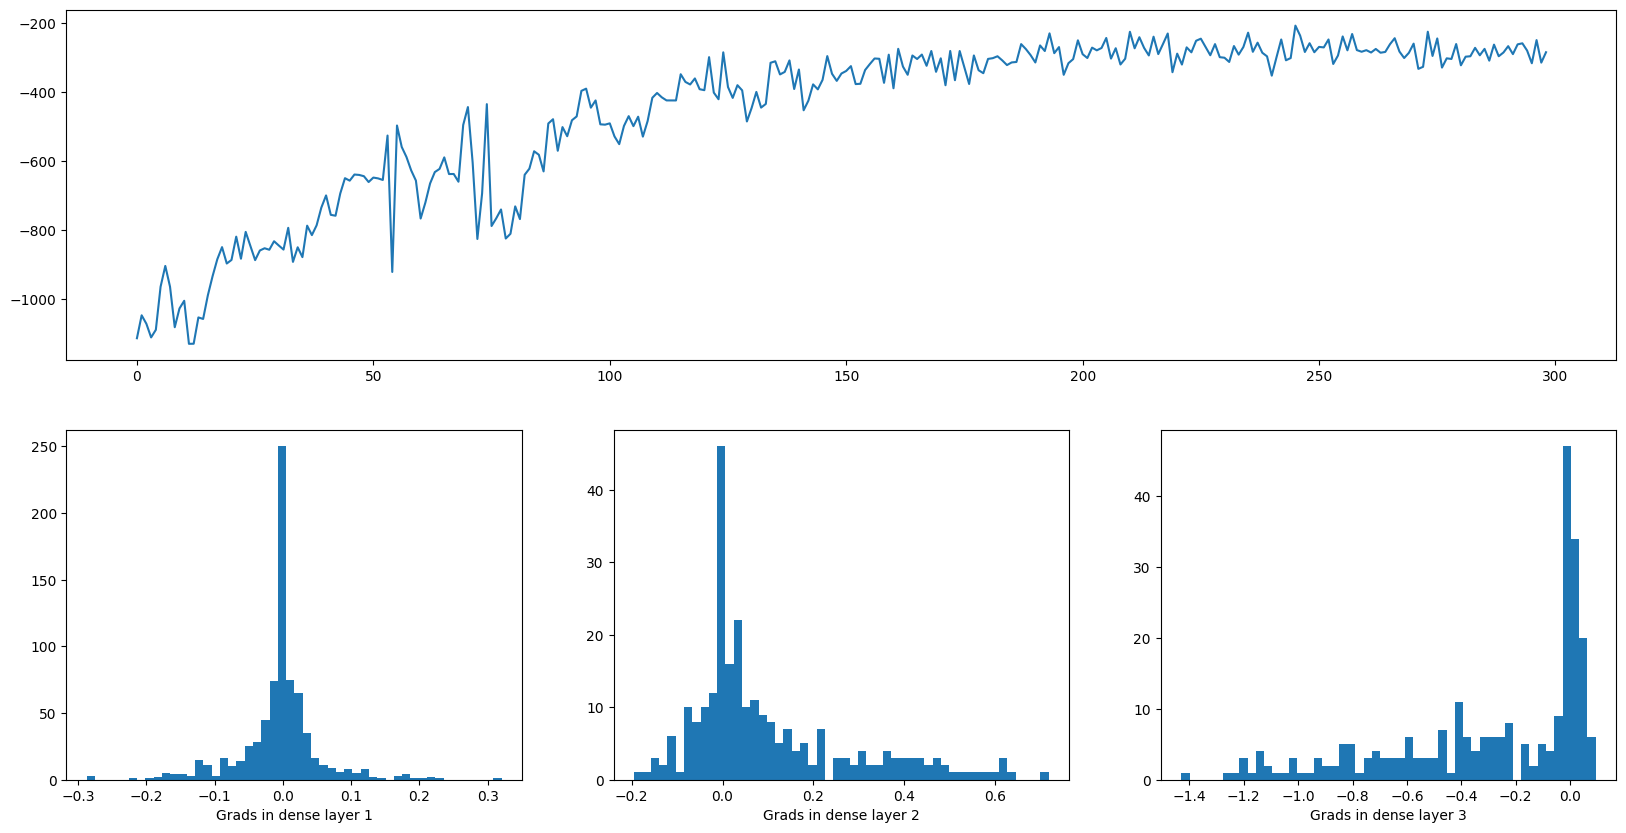

In [121]:
model = ParameterisedPolicy()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4000, gamma=0.5)

rews = []
for _ in range(int(15e3)):
    rewards, logits = play_game(env, model, n_steps=150, render=False)
    
    cum_rewards = create_cum_rewards(rewards, discount=DISCOUNT)
    stacked_logits = torch.stack(logits).flatten()
    loss = -(stacked_logits * cum_rewards).mean()

    rews.append(np.sum(rewards))

    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 50)
    opt.step()
    lr_scheduler.step()
    
    if _%50 == 0:
        if _ > 1:
            clear_output()
            draw_gradients_rewards(model, rewards=rews)
            plt.show()
            
    if check_for_bad_gradients(model, threshold=1e3):
        clear_output()
        draw_gradients_rewards(model, rewards=rews)
        plt.show()
        print('Step', _)
        print('KABOOOOOOOOM!!!'*30)
        break
        
    

In [127]:
rewards, logits = play_game(env, model, n_steps=200, render=True)

The model has learnt an ok policy, but we see several significant drops of sum rewards on the graph above. 
Those indicate drops in policy performance, i.e. update steps that were too big and in the wrong direction.
From the perspective of training the neural net, it could be partially dealt with by further experimenting with 
the architecture. But it also could be approached from the policy iteration perspective. We will come back to it later.

 For now we will see how our model works on the env that is one step closer to the target env.

# Continous REINFORCE with clipped gradients on LunarLanderContinuous-v2

Unlike in previous envs we tried, actions here are multidimensional. 
Because of this we need to adjust what is predicted and how loss is calculated. In particular, we now output 6 numbers, beings mu_s and sigma_s, for 3 separate distributions. In the loss calculation we sum the log probabilities along the actions axis, since log of multiplication is a sum of logs.

In [2]:
env_name = 'LunarLanderContinuous-v2'#'RocketLander-v0'

DISCOUNT = .99

env = gym.make(env_name)
init_state = env.reset()
obs_len = len(init_state)

class ParameterisedPolicy(torch.nn.Module):
    
    def __init__(self, obs_len=obs_len):
        super().__init__()
        self.obs_len = obs_len
        self.lin_1 = torch.nn.Linear(self.obs_len, 256)
        self.rel_1 = torch.nn.ReLU()
        
        self.lin_2 = torch.nn.Linear(256, 128)
        self.rel_2 = torch.nn.ReLU()
            
        self.lin_3 = torch.nn.Linear(128, 3)
        
        self.lin_4 = torch.nn.Linear(128, 3)
        self.elu = torch.nn.ELU()
        
        
    def forward(self, x):
        x = self.lin_1(x)
        x = self.rel_1(x)
        
        x = self.lin_2(x)
        x = self.rel_2(x)
        
        mu = self.lin_3(x)
        
        x = self.lin_4(x)
        sigma = self.elu(x) + 1.000001
        
        return mu, sigma

In [3]:
def create_cum_rewards(rewards, discount=DISCOUNT):
    new_rews = [0]
    for el in rewards[::-1]:
        val = el + discount * new_rews[-1]
        new_rews.append(val)
    return torch.tensor(new_rews[1:][::-1], dtype=torch.float32)


def play_game(env, model, n_steps=500, render=False):
    observation = env.reset()

    rewards, logits = [], []
#     for _ in range(n_steps):
    while True:
        if render:
            env.render()
            
        (mus, sigmas) = model(torch.tensor(observation, dtype=torch.float32))
        
        m = torch.distributions.normal.Normal(mus, sigmas)
        action = m.sample()
        logit = m.log_prob(action)
        observation, reward, done, info = env.step(action.detach().numpy())

        rewards.append(reward)
        logits.append(m.log_prob(action).sum())
        
        if done:
            break
    env.close()
    
    return rewards, logits

def draw_gradients_rewards(model, rewards, ep_lengths, ave_over_steps):
    
    fig, axs = plt.subplot_mosaic([['1', '1', '2', '2'], ['3', '4', '5', '6']],
                                  constrained_layout=False, figsize=(20, 9))

    axs['1'].plot(np.array(rewards[:ave_over_steps*(len(rewards)//ave_over_steps)])\
                    .reshape(-1, ave_over_steps).mean(axis=-1))
    axs['1'].set_title('Sum rewards per episode')
    
    axs['1'].hlines(200, 0, len(rewards)/ave_over_steps, colors='red')
    axs['1'].hlines(150, 0, len(rewards)/ave_over_steps, colors='orange')
    axs['1'].hlines(0, 0, len(rewards)/ave_over_steps, colors='green')
    
    axs['2'].plot(np.array(ep_lengths[:ave_over_steps*(len(ep_lengths)//ave_over_steps)])\
                    .reshape(-1, ave_over_steps).mean(axis=-1))
    axs['2'].set_title('Episode length')
    
    axs['3'].hist(model.lin_1.weight.grad.flatten().detach().numpy(), bins=50); 
    axs['3'].set_xlabel('Grads in dense layer 1')

    axs['4'].hist(model.lin_2.weight.grad.flatten().detach().numpy(), bins=50); 
    axs['4'].set_xlabel('Grads in dense layer 2')

    axs['5'].hist(model.lin_3.weight.grad.flatten().detach().numpy(), bins=50); 
    axs['5'].set_xlabel('Grads in dense layer 3')
    
    axs['6'].hist(model.lin_4.weight.grad.flatten().detach().numpy(), bins=50); 
    axs['6'].set_xlabel('Grads in dense layer 4')

def check_for_bad_gradients(model, threshold=1e6):
    flag = False
    all_grads = list(model.lin_1.weight.grad.flatten().detach().numpy()) + \
                list(model.lin_2.weight.grad.flatten().detach().numpy()) + \
                list(model.lin_3.weight.grad.flatten().detach().numpy())
    
    if any(abs(np.array(all_grads)) >= threshold):
        flag = True
    return flag

Checking for explosions

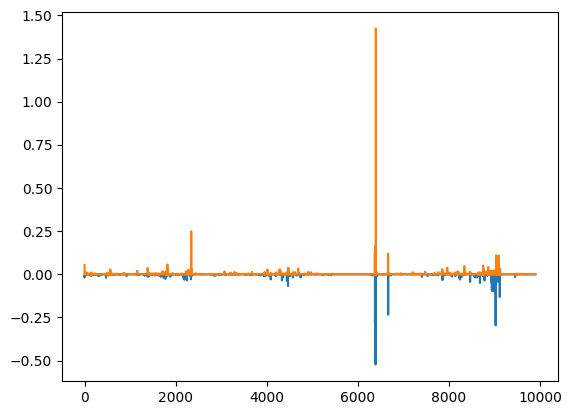

In [41]:
model = ParameterisedPolicy()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

rews, grads_perc_10, grads_perc_90 = [], [], []
for _ in range(int(1e4)):
    rewards, logits = play_game(env, model, n_steps=20, render=False)
    
    cum_rewards = create_cum_rewards(rewards, discount=DISCOUNT)
    stacked_logits = torch.stack(logits).flatten()
    loss = -(stacked_logits * cum_rewards).mean()

    rews.append(np.sum(rewards))

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    all_grads = list(model.lin_1.weight.grad.flatten().detach().numpy()) + \
                list(model.lin_2.weight.grad.flatten().detach().numpy()) + \
                list(model.lin_3.weight.grad.flatten().detach().numpy())
    grads_perc_10.append(np.percentile(all_grads, 10))
    grads_perc_90.append(np.percentile(all_grads, 90))
    
    if _%100==0:
        clear_output()
        plt.plot(grads_perc_10)
        plt.plot(grads_perc_90)
#         plt.ylim(-.1, .1)
        plt.show()

No explosions, but let's keep the clip value at 50 just in case

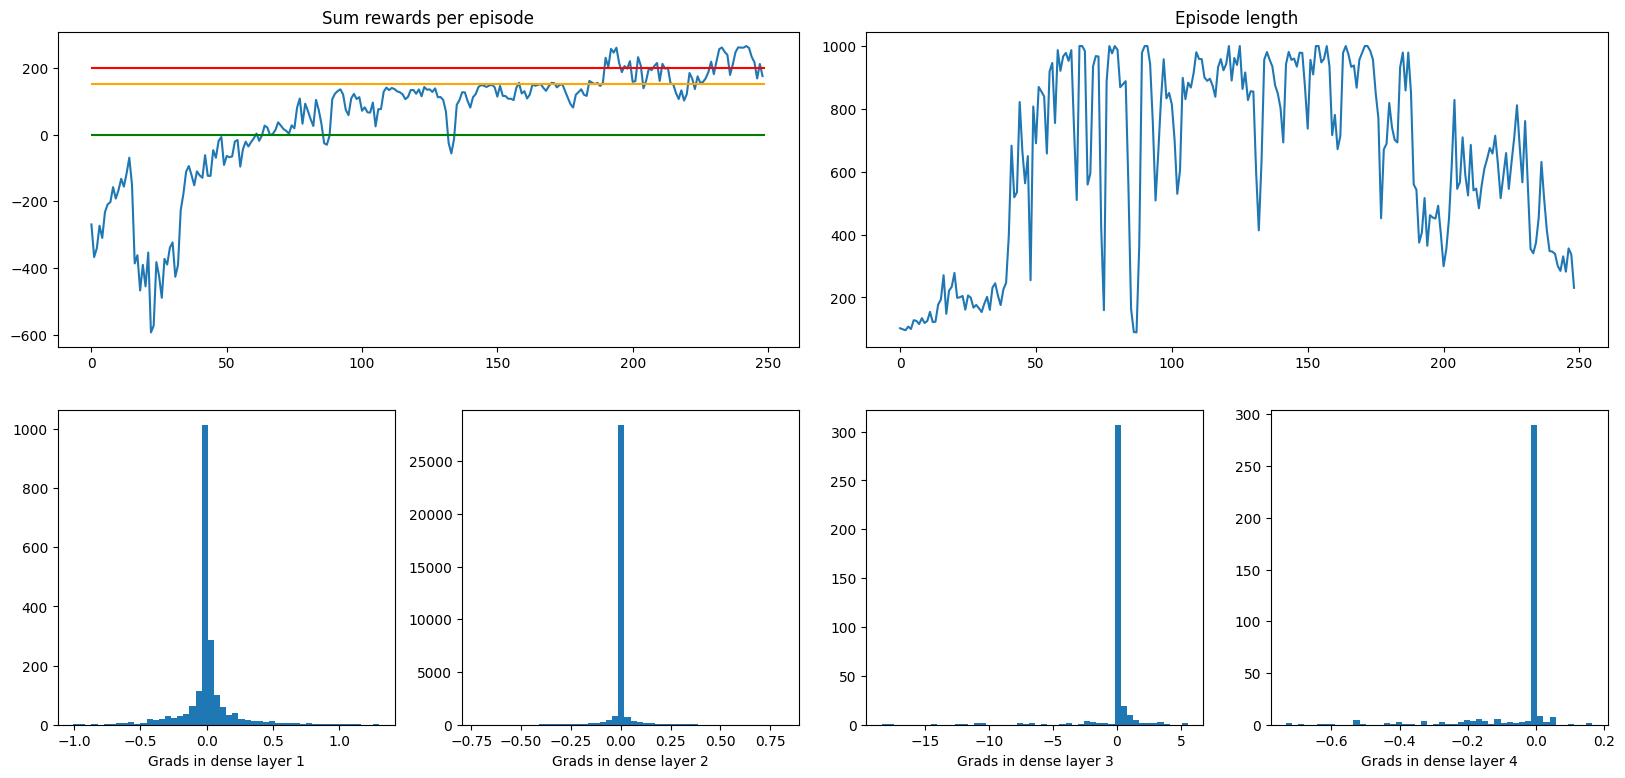

In [9]:
model = ParameterisedPolicy()
opt = torch.optim.Adam(model.parameters(), lr=0.0008)
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4000, gamma=0.7)
rews, ep_lengths = [], []

last_max_score = 50
env = gym.make(env_name)
for _ in range(int(10e3)):
    rewards, logits = play_game(env, model, render=False)
    
    cum_rewards = create_cum_rewards(rewards, discount=DISCOUNT)
    stacked_logits = torch.stack(logits).flatten()
    
#     entropy = -(stacked_logits.exp() * stacked_logits).sum()
    loss = -(stacked_logits * cum_rewards).mean()#- 2e-3 * entropy)
    
    rews.append(np.sum(rewards))
    ep_lengths.append(len(rewards))

    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 50)
    opt.step()
    lr_scheduler.step()
    
    if _%40 == 0:
        if _ > 1:
            clear_output()
            draw_gradients_rewards(model, rewards=rews, 
                                   ep_lengths=ep_lengths, ave_over_steps=40)
            plt.show()
            
    if len(rews) > 40:
        agg_rews = np.array(rews[-40*(len(rews)//40):])\
                        .reshape(-1, 40).mean(axis=-1) 
        if (agg_rews[-1] > last_max_score):
            last_max_score = agg_rews[-1]
            print('NEW BEST MODEL, STEP:', _, 'SCORE: ', last_max_score)
            save_path = f'best_models/best_reinforce_lunar_lander_cont_model_{round(last_max_score,3)}.pt'
            torch.save(model, save_path)
    
    if np.mean(rews[:40]) >= 200:
        print('YAOOZAAAAAAAAAAAAA!!!!!! '*30)
        break

The environment is considered solved if the sum reward per episode reaches 200, so we managed to solve it, 
best model gives the score of 264.10 with std 37.17. 
The model is uploaded to HF: https://huggingface.co/igorcheb/REINFORCE-LunarLanderContinuous-v2

Let's now add batches and try the reinforce agent on the target env.

# Adding batches

In [2]:
DISCOUNT = .99
BATCH_SIZE = 8
GRAD_CLIP_VALUE = 50
GRAPH_SMOOTHING_LEN = 5

We will move the action taking code to the agent and add the calc_loss_function

In [8]:
env_name = 'LunarLanderContinuous-v2'#'RocketLander-v0'

env = gym.make(env_name)
init_state = env.reset()
obs_len = len(init_state)

class ParameterisedPolicy(torch.nn.Module):
    
    def __init__(self, obs_len=obs_len):
        super().__init__()
        self.obs_len = obs_len
        self.lin_1 = torch.nn.Linear(self.obs_len, 256)
        self.rel_1 = torch.nn.ReLU()
        
        self.lin_2 = torch.nn.Linear(256, 128)
        self.rel_2 = torch.nn.ReLU()
            
        self.lin_3 = torch.nn.Linear(128, 3)
        
        self.lin_4 = torch.nn.Linear(128, 3)
        self.elu = torch.nn.ELU()
        
        
    def forward(self, x):
        x = self.lin_1(x)
        x = self.rel_1(x)
        
        x = self.lin_2(x)
        x = self.rel_2(x)
        
        mu = self.lin_3(x)
        
        x = self.lin_4(x)
        sigma = self.elu(x) + 1.000001
        
        return mu, sigma

    def act(self, observation):
        
        (mus, sigmas) = self.forward(torch.tensor(observation, dtype=torch.float32))
        m = torch.distributions.normal.Normal(mus, sigmas)
        tens_action = m.sample()
        logit = m.log_prob(tens_action).sum()
        action = tens_action.detach().numpy()
        
        return (action, logit)

def create_cum_rewards(rewards, discount=DISCOUNT):
    new_rews = [0]
    for el in rewards[::-1]:
        val = el + discount * new_rews[-1]
        new_rews.append(val)
    return torch.tensor(new_rews[1:][::-1], dtype=torch.float32)



def play_single_game(env, model, n_steps=1000, render=False):
    observation = env.reset()

    rewards, logits = [], []
    for _ in range(n_steps):
        if render:
            env.render()
        
        (action, logit) = model.act(torch.tensor(observation, dtype=torch.float32))
        
        observation, reward, done, info = env.step(action)
            
        rewards.append(reward)
        logits.append(logit)
        
        if done:
            break
    env.close()
    
    return rewards, logits

def calc_loss(rewards, logits):
    cum_rewards = create_cum_rewards(rewards, discount=DISCOUNT)
    stacked_logits = torch.stack(logits).flatten()
    
#     entropy = -(stacked_logits.exp() * stacked_logits).sum()
    return -(stacked_logits * cum_rewards).mean()#- 2e-3 * entropy)

In [225]:
#test code
env_name = 'LunarLanderContinuous-v2'
env = gym.make(env_name)
agent = ParameterisedPolicy()

observation = env.reset()
r, l = play_single_game(env, agent, render=True)

/var/folders/p3/4j53xc_50yv4yqz952bnybrm0000gn/T/ipykernel_8854/1541312663.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (mus, sigmas) = self.forward(torch.tensor(observation, dtype=torch.float32))


Now instead of calculating loss from a single trajectory (episode), we will play several games and use average loss from those to optimise on

In [4]:
def play_batch(env, agent, batch_size=25, render=False):
    all_losses, all_lengths, all_rewards = [], [], []
    for _ in range(batch_size):
        game_rewards, game_logits = play_single_game(env, agent, n_steps=1000, render=render)

        all_losses.append(calc_loss(game_rewards, game_logits))
        all_lengths.append(len(game_rewards))
        all_rewards.append(sum(game_rewards))
        
    return torch.stack(all_losses).mean(), np.mean(all_rewards), int(np.mean(all_lengths))

In [227]:
# test code
mean_loss, mean_rewards, mean_ep_len = play_batch(env, agent)
mean_loss, mean_rewards, mean_ep_len

/var/folders/p3/4j53xc_50yv4yqz952bnybrm0000gn/T/ipykernel_8854/1541312663.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (mus, sigmas) = self.forward(torch.tensor(observation, dtype=torch.float32))


(tensor(-1517.3466, grad_fn=<MeanBackward0>), -495.5304339887313, 28)

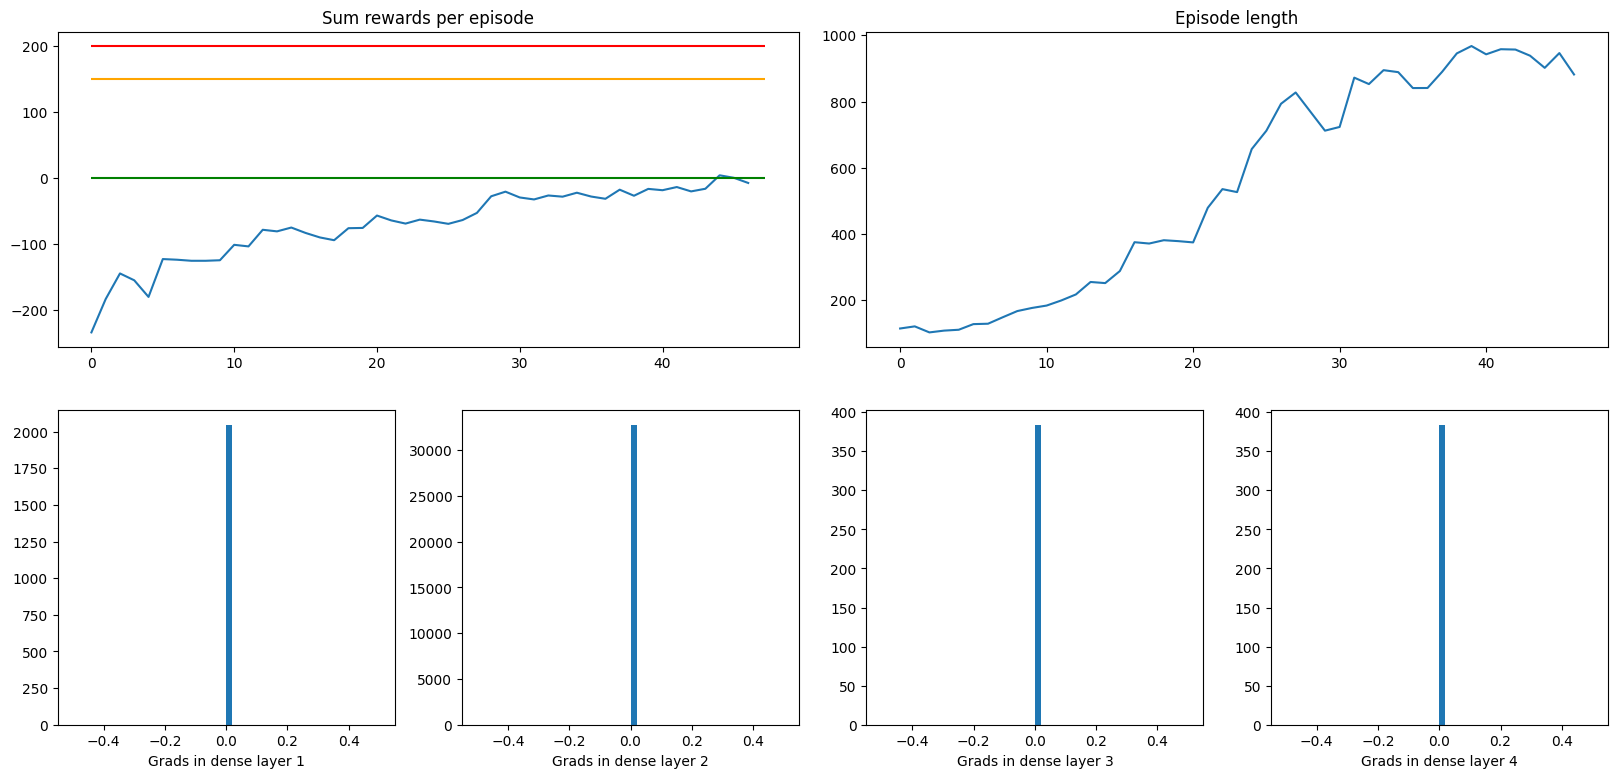

KeyboardInterrupt: 

In [151]:
# test code
agent = ParameterisedPolicy()
opt = torch.optim.Adam(agent.parameters(), lr=0.0008)
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4000, gamma=0.7)
rews, ep_lengths = [], []

env = gym.make(env_name)
for _ in range(int(10e3)):
    mean_loss, mean_rewards, mean_ep_len = play_batch(env, agent, render=False)

    rews.append(mean_rewards)
    ep_lengths.append(mean_ep_len)

    opt.zero_grad()
    mean_loss.backward()
    torch.nn.utils.clip_grad_norm_(agent.parameters(), GRAD_CLIP_VALUE)
    opt.step()
    lr_scheduler.step()
    
    if _%GRAPH_SMOOTHING_LEN == 0:
        if _ > 1:
            clear_output()
            draw_gradients_rewards(agent, rewards=rews, 
                                   ep_lengths=ep_lengths, ave_over_steps=GRAPH_SMOOTHING_LEN)
            plt.show()

The sum reward dynamics here is much more smooth.
Now let's see what the performance on the target env will be. Because the previous env we tried is very similar, no changes to code is required, except maybe for the grad clip value due to different reward values.

In [9]:
def draw_gradients_rewards(model, rewards, ep_lengths, ave_over_steps, score_thresholds = []):
    
    fig, axs = plt.subplot_mosaic([['1', '1', '2', '2'], ['3', '4', '5', '6']],
                                  constrained_layout=False, figsize=(20, 9))

    axs['1'].plot(np.array(rewards[:ave_over_steps*(len(rewards)//ave_over_steps)])\
                    .reshape(-1, ave_over_steps).mean(axis=-1))
    axs['1'].set_title('Sum rewards per episode')
    
    for thresh in score_thresholds:
        axs['1'].hlines(thresh, 0, len(rewards)/ave_over_steps, color='orange')
    
    axs['2'].plot(np.array(ep_lengths[:ave_over_steps*(len(ep_lengths)//ave_over_steps)])\
                    .reshape(-1, ave_over_steps).mean(axis=-1))
    axs['2'].set_title('Episode length')
    
    axs['3'].hist(model.lin_1.weight.grad.flatten().detach().numpy(), bins=50); 
    axs['3'].set_xlabel('Grads in dense layer 1')

    axs['4'].hist(model.lin_2.weight.grad.flatten().detach().numpy(), bins=50); 
    axs['4'].set_xlabel('Grads in dense layer 2')

    axs['5'].hist(model.lin_3.weight.grad.flatten().detach().numpy(), bins=50); 
    axs['5'].set_xlabel('Grads in dense layer 3')
    
    axs['6'].hist(model.lin_4.weight.grad.flatten().detach().numpy(), bins=50); 
    axs['6'].set_xlabel('Grads in dense layer 4')

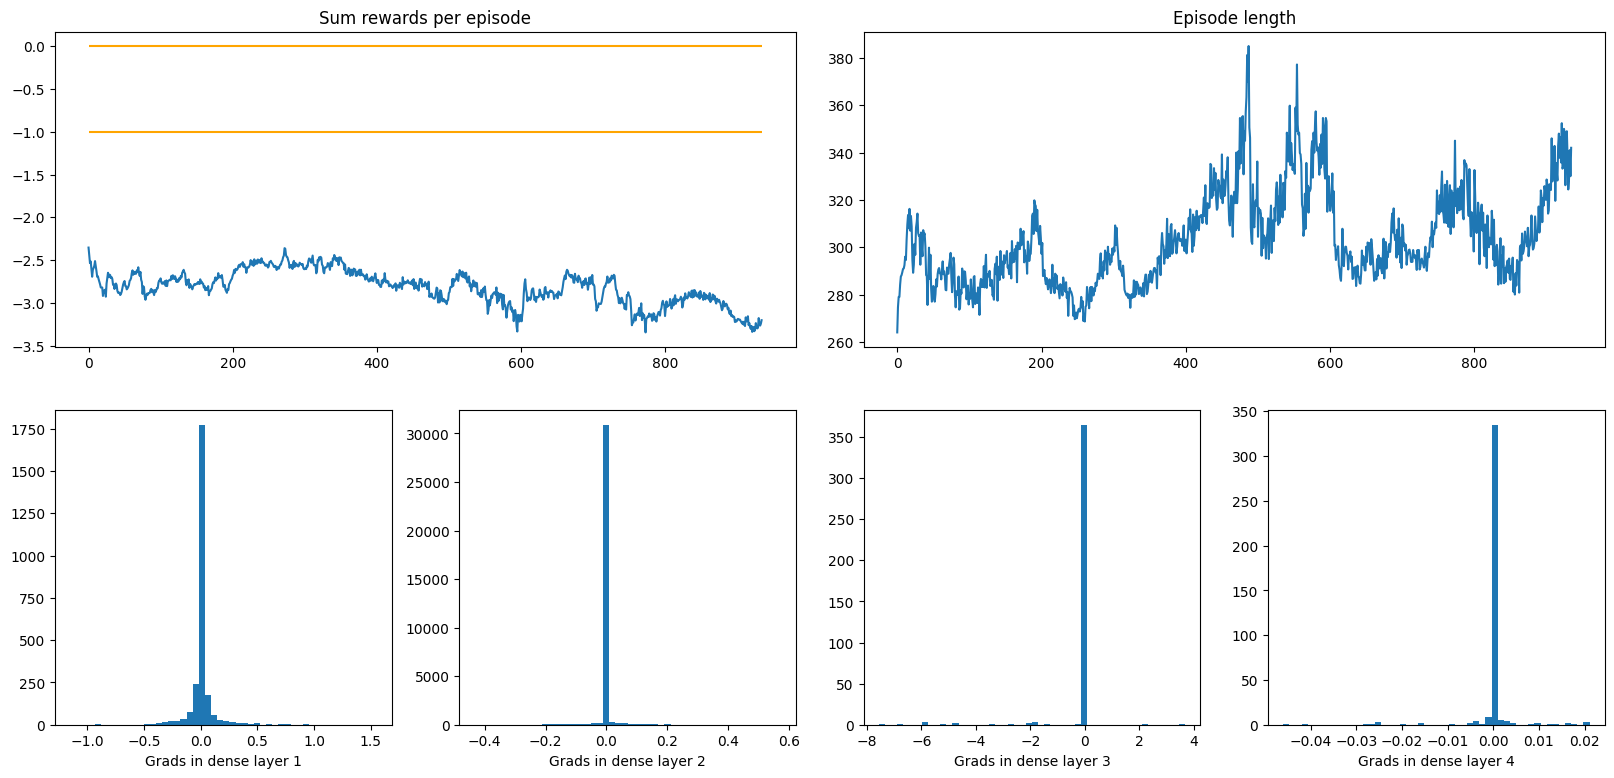

KeyboardInterrupt: 

In [10]:
DISCOUNT = .97
BATCH_SIZE = 8
GRAD_CLIP_VALUE = 20
GRAPH_SMOOTHING_LEN = 5

env_name = 'RocketLander-v0'

env = gym.make(env_name)
init_state = env.reset()
obs_len = len(init_state)

agent = ParameterisedPolicy(obs_len)
opt = torch.optim.Adam(agent.parameters(), lr=0.0008)
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4000, gamma=0.7)
rews, ep_lengths = [], []

for _ in range(int(20e3)):
    mean_loss, mean_rewards, mean_ep_len = play_batch(env, agent, render=False)

    rews.append(mean_rewards)
    ep_lengths.append(mean_ep_len)

    opt.zero_grad()
    mean_loss.backward()
    torch.nn.utils.clip_grad_norm_(agent.parameters(), GRAD_CLIP_VALUE)
    opt.step()
    lr_scheduler.step()
    
    if _%GRAPH_SMOOTHING_LEN == 0:
        if _ > 1:
            clear_output()
            draw_gradients_rewards(agent, rewards=rews, 
                                   ep_lengths=ep_lengths, 
                                   ave_over_steps=GRAPH_SMOOTHING_LEN,
                                   score_thresholds=[-1, 0]) 
            plt.show()

Agent fails to learn, the environment is too complicated for such a simple policy. We will now attempt to reduce the policy variance by adding a critic and see how an angent learns on environment already solved.